In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl
import tensorflow as tf
import math

In [2]:
with open('isolet_crop_train.pkl', 'rb') as f:
    train_data = pkl.load(f)
with open('isolet_crop_test.pkl', 'rb') as f:
    test_data = pkl.load(f)
    
X_train, y_train = train_data
X_test, y_test = test_data
y_train = y_train - 1 
y_test = y_test - 1  


In [3]:
# Get training Data statistics

# Number of Training examples
n_train = len(X_train)
# Number of Testing examples
n_test = len(X_test)
# Number of Training features
n_TrainFeatures = len(X_train[0])
# Number of Testing features (should be equal to that of training)
n_TestFeatures = len (X_test[0])
# Number of Training classes
n_TrainClasses =  len(np.unique(y_train))
# Number of Testing Classes (should be equal to that of training)
n_TestClasses = len(np.unique(y_test))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("....")
print("Number of Training features =", n_TrainFeatures)
print("Number of Testing features =", n_TestFeatures)
print("....")
print("Number of Training Classes =", n_TrainClasses)
print("Number of Testing Classes =", n_TestClasses)

Number of training examples = 6238
Number of testing examples = 1559
....
Number of Training features = 300
Number of Testing features = 300
....
Number of Training Classes = 26
Number of Testing Classes = 26


##  a) Make yourself familiar with the dataset. Normalize each feature to zero mean and unitvariance.

In [4]:
#X_train, y_train = train_data
#X_test, y_test = test_data

X_mean = np.mean(X_train, axis=0)
X_std = np.std(X_train, axis=0)

# Training data normalization
X_train = (X_train - X_mean) / X_std

# Testing data normalization
X_test = (X_test - X_mean) / X_std

# Split Data

In [5]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train,y_train)

from sklearn.model_selection import train_test_split
# First split in 70% -- 30%
X_train2, X_temp, y_train2, y_temp  = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

#Split the 30% into half to get 15% -- 15% (from X_train)for validation and early stop
X_validation, X_stop, y_validation, y_stop = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

n_input = len(X_train2)

In [6]:
print(X_train.shape)
print(y_train.shape)
print(X_train2.shape)
print(y_train2.shape)
print(X_validation.shape)
print(y_validation.shape)
print(X_stop.shape)
print(y_stop.shape)

(6238, 300)
(6238,)
(4366, 300)
(4366,)
(936, 300)
(936,)
(936, 300)
(936,)


## one-out-of-K coding

tf.reset_default_graph()

x = tf.placeholder(tf.float32, (None, 300))
y = tf.placeholder(tf.int32,(None))
one_hot_y = tf.one_hot(y, 26)


# Network

In [85]:
def Train_Classifier(x, Layers = [20,26],activation = tf.sigmoid):
    M = x.get_shape().as_list()[1] #300
    #M = float(M)
    C = Layers[-1] #26
    n_layers = len(Layers)
    Layers = np.insert(Layers,0,M)
    W = []
    b = []
    a = []
    z = []
    #min_d = 1./math.sqrt(300)
    for i in range(n_layers):        
        b.append(tf.Variable(tf.zeros(Layers[i+1]),name='bias_{}'.format(i)))
        if i == 0:
            min_d = 1./math.sqrt(300)
            W.append(tf.Variable(tf.random_uniform([Layers[i], Layers[i+1]],-min_d,min_d),name='weights_{}'.format(i)))
            a.append(tf.add(tf.matmul(x,W[i]),b[i]))
        else:
            min_d = 1./math.sqrt(Layers[i-1])
            W.append(tf.Variable(tf.random_uniform([Layers[i], Layers[i+1]],-min_d,min_d),name='weights_{}'.format(i)))
            a.append(tf.add(tf.matmul(z[i-1],W[i]),b[i]))
        z.append(activation(a[i]))
        
    #change here   
    if activation == tf.nn.relu:
        print("Initializing RELU-------------------------------")
        W = []
        b = []
        a = []
        z = []
        for i in range(n_layers):        
            b.append(tf.Variable(tf.zeros(Layers[i+1]),name='bias_{}'.format(i)))
            #W.append(tf.Variable(tf.truncated_normal([Layers[i], Layers[i+1]],stddev=0.01),name='weights_{}'.format(i)))
           
            if i == 0:
                min_d = 1./math.sqrt(300)
                W.append(tf.Variable(tf.random_uniform([Layers[i], Layers[i+1]],0,min_d),name='weights_{}'.format(i)))
                a.append(tf.add(tf.matmul(x,W[i]),b[i]))
            else:
                min_d = 1./math.sqrt(Layers[i-1])
                W.append(tf.Variable(tf.random_uniform([Layers[i], Layers[i+1]],0,min_d),name='weights_{}'.format(i)))
                a.append(tf.add(tf.matmul(z[i-1],W[i]),b[i]))
            z.append(activation(a[i]))
    logits =  a[-1]

    return logits

In [ ]:
tf.truncated_normal

In [42]:
def evaluate(X_data, y_data,accuracy_operation):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    
    return total_accuracy / num_examples  

In [43]:
def network(logits,opt,rate):
    #rate = 0.1 # learning rate
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
    loss_operation = tf.reduce_mean(cross_entropy)
    optimizer = opt(learning_rate=rate)
    training_operation = optimizer.minimize(loss_operation)   
    
    correct_prediction = tf.equal(tf.argmax(logits,1), tf.argmax(one_hot_y,1))
    accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    return training_operation,accuracy_operation

In [44]:
def train(logits, opt, rate,stop_on_convergence = True,ret = 'model'):
    #save_file = './modelTest1.ckpt'
    
    training_operation,accuracy_operation = network(logits,opt,rate)
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train2)

    TempValidat_acc_list = []
    TempTrain_acc_list = []
    TempEarlyStopping_acc_list = []

    validat_acc_list = []
    train_acc_list = []
    earlyStoping_acc_list = []

    earlyStoppingMax = -1
    val_for_best_model = -1

    for i in range(EPOCHS):
         
        X_train21, y_train21 = shuffle(X_train2,y_train2)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train21[offset:end], y_train21[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})

        validation_accuracy = evaluate(X_validation, y_validation,accuracy_operation)
        training_accuracy = evaluate(X_train2, y_train2,accuracy_operation)
        earlyStoping_accuracy = evaluate(X_stop,y_stop,accuracy_operation)

        if earlyStoppingMax < earlyStoping_accuracy:
            earlyStoppingMax = earlyStoping_accuracy
            val_for_best_model = validation_accuracy
        
        TempValidat_acc_list.append(validation_accuracy)
        TempTrain_acc_list.append(training_accuracy)
        TempEarlyStopping_acc_list.append(earlyStoping_accuracy)

        
        if i%STEP_SIZE == 0:
            validat_acc_list.append(np.mean(TempValidat_acc_list))
            TempValidat_acc_list = []

            train_acc_list.append(np.mean(TempTrain_acc_list))
            TempTrain_acc_list = []           

            earlyStoping_acc_list.append(np.mean(TempEarlyStopping_acc_list))
            TempEarlyStopping_acc_list = []  

            if stop_on_convergence and len(validat_acc_list) > 1:
                if validat_acc_list[-1] < validat_acc_list[-2] - 1e-3:
                    print("#############STOP################")
                    break
                    
    if ret == 'plots':
        return train_acc_list,validat_acc_list,earlyStoping_acc_list
    elif ret == 'error':
        return 1-val_for_best_model
    elif ret == 'model':
        return 0  

In [45]:
tf.reset_default_graph()
x = tf.placeholder(tf.float32, (None, 300))
y = tf.placeholder(tf.int32,(None))
one_hot_y = tf.one_hot(y, 26)

In [52]:
EPOCHS = 300
BATCH_SIZE = 40
INDP_RUNS = 2
STEP_SIZE = 10

def try_comb(classifier,optimizer, rate):
    err = 0
    for i in range(INDP_RUNS):
        err += train(classifier,optimizer,rate)
    return err / INDP_RUNS

with tf.Session() as sess:
    result = try_comb(Train_Classifier(x) , tf.train.RMSPropOptimizer,0.005)
    print(result)

In [53]:
def try_comb(classifier,optimizer, rate):
    train_list, val_list, es_list = train(classifier,optimizer,rate,stop_on_convergence = False,ret = 'plots')
    train_list = np.array(train_list)
    val_list = np.array(val_list)
    es_list = np.array(es_list)
    for i in range(INDP_RUNS-1):
        tr, va, es = train(classifier,optimizer,rate,stop_on_convergence = False,ret = 'plots')
        train_list = train_list + np.array(tr)
        val_list =val_list + np.array(va)
        es_list = es_list + np.array(es)
    return np.divide(train_list,INDP_RUNS),np.divide(val_list,INDP_RUNS),np.divide(es_list,INDP_RUNS)

### Now we compare the rates for each optimizing algorithm and choose the best ones
#### The architecture is fixed for comparison which is one hidden layer with the same number of neurons and the number of epochs is fixed too

##  <font color='red'> Start Optimization Function Check </font>

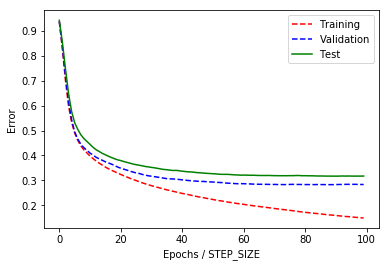

Accuracy of rate 0.01 = 0.7163034193867291, es = 0.6828098276257516, epch = 90


In [117]:
EPOCHS = 1000
BATCH_SIZE = 40
INDP_RUNS = 10
STEP_SIZE = 10

#sgd_rates = np.array([0.05,0.06,0.07,0.01,0.1])
#sgd_rates = np.array([0.07,0.05])
#sgd_rates = np.array([0.05,0.08])
sgd_rates = np.array([0.01])

for rate in sgd_rates:
    #changed here
    tf.reset_default_graph()
    x = tf.placeholder(tf.float32, (None, 300))
    y = tf.placeholder(tf.int32,(None))
    one_hot_y = tf.one_hot(y, 26)
    with tf.Session() as sess:
        tr,va,es = try_comb(Train_Classifier(x,[20,26]) , tf.train.GradientDescentOptimizer,rate)
              
        plt.xlabel('Epochs / STEP_SIZE')
        plt.ylabel('Error')
        plt.plot(1 - np.array(tr),'r--',label = 'Training')
        plt.plot(1 - np.array(va),'b--', label = 'Validation')
        plt.plot(1 - np.array(es),'g', label = 'Test')
        plt.legend(loc='best')
        plt.show()
        print('Accuracy of rate {} = {}, es = {}, epch = {}'.format(rate,va[np.argmax(es)],np.max(es),np.argmax(es)))

## Changed Here
#### Based on the comparison, we see that $rate = 0.1$ is the best choice for SGD with $acc = 0.689$

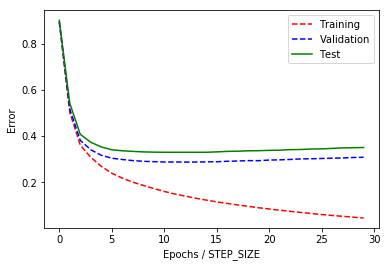

Accuracy of rate 0.0008 = 0.7120192300636544, es = 0.6697435896926456, epch = 13


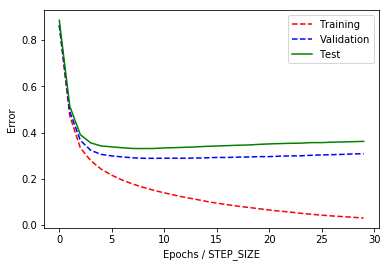

Accuracy of rate 0.001 = 0.711645300645604, es = 0.6694444436955655, epch = 8


In [69]:
#rms_rates = np.array([0.001,0.005,0.008,0.01,0.05])

EPOCHS = 300
BATCH_SIZE = 40
INDP_RUNS = 10
STEP_SIZE = 10

#rms_rates = np.array([0.0005,0.001,0.0015,0.002,0.0008])
#rms_rates = np.array([0.001,0.0015,0.0008])
rms_rates = np.array([0.0008,0.001])
for rate in rms_rates:
    #changed here
    tf.reset_default_graph()
    x = tf.placeholder(tf.float32, (None, 300))
    y = tf.placeholder(tf.int32,(None))
    one_hot_y = tf.one_hot(y, 26)
    with tf.Session() as sess:
        tr,va,es = try_comb(Train_Classifier(x,[20,26]) , tf.train.RMSPropOptimizer,rate)
        plt.xlabel('Epochs / STEP_SIZE')
        plt.ylabel('Error')
        plt.plot(1 - np.array(tr),'r--',label = 'Training')
        plt.plot(1 - np.array(va),'b--', label = 'Validation')
        plt.plot(1 - np.array(es),'g', label = 'Test')
        plt.legend(loc='best')
        plt.show()
        print('Accuracy of rate {} = {}, es = {}, epch = {}'.format(rate,va[np.argmax(es)],np.max(es),np.argmax(es)))

## Changed Here
#### Based on the comparison, we see that $rate = 0.0008$ is the best choice for RMSProp with $acc = 0.7156$

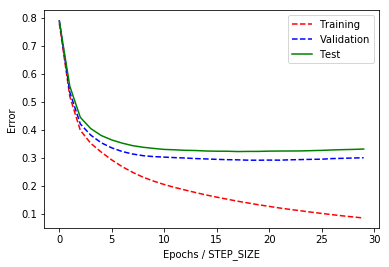

Accuracy of rate 0.0005 = 0.7068589741501032, es = 0.6772329065585749, epch = 17


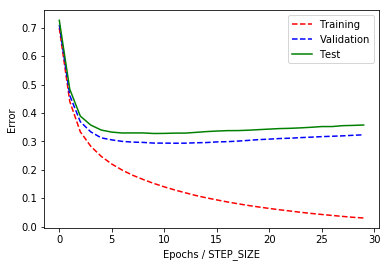

Accuracy of rate 0.001 = 0.7059935900467075, es = 0.6722970088195598, epch = 9


In [70]:
EPOCHS = 300
BATCH_SIZE = 40
INDP_RUNS = 10
STEP_SIZE = 10
#adam_rates = np.array([0.0002,0.0005,0.0007,0.0008,0.00085,0.0009,0.00095])
adam_rates = np.array([0.0005,0.001])
for rate in adam_rates:
    #changed here
    tf.reset_default_graph()
    x = tf.placeholder(tf.float32, (None, 300))
    y = tf.placeholder(tf.int32,(None))
    one_hot_y = tf.one_hot(y, 26)
    with tf.Session() as sess:
        tr,va,es = try_comb(Train_Classifier(x,[20,26]) , tf.train.AdamOptimizer,rate)
        plt.xlabel('Epochs / STEP_SIZE')
        plt.ylabel('Error')
        plt.plot(1 - np.array(tr),'r--',label = 'Training')
        plt.plot(1 - np.array(va),'b--', label = 'Validation')
        plt.plot(1 - np.array(es),'g', label = 'Test')
        plt.legend(loc='best')
        plt.show()
        print('Accuracy of rate {} = {}, es = {}, epch = {}'.format(rate,va[np.argmax(es)],np.max(es),np.argmax(es)))

## Change Here
#### Based on the comparison, we see that $rate = 0.0005$ is the best choice for ADAM with $acc = 0.706$

##  <font color='red'> Start Activation Function Check </font>

Initializing RELU-------------------------------


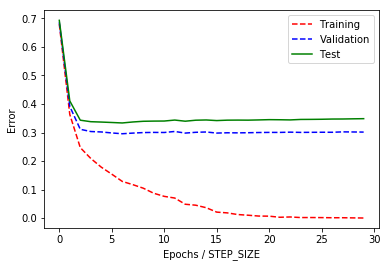

Accuracy with activation ReLU with opt: 'SGD' = 0.7041987182569299, es = 0.6664209397531982
Initializing RELU-------------------------------


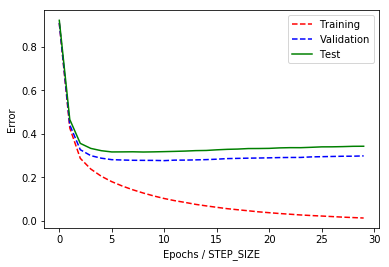

Accuracy with activation ReLU with opt: 'RMS' = 0.7217094018775173, es = 0.6833012817659949
Initializing RELU-------------------------------


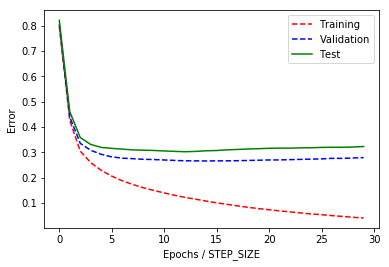

Accuracy with activation ReLU with opt: 'ADAM' = 0.7332478635739058, es = 0.6974252139324815


In [121]:
EPOCHS = 300
BATCH_SIZE = 40
INDP_RUNS = 10
STEP_SIZE = 10

Algo = [tf.nn.relu]
names = ['ReLU']
Opt = [tf.train.GradientDescentOptimizer,tf.train.RMSPropOptimizer, tf.train.AdamOptimizer]
#change here
rates = [0.1,0.0008, 0.0005]
Opt_name = ['SGD','RMS','ADAM']
for i in range(len(Algo)):
    #change here
    tf.reset_default_graph()
    x = tf.placeholder(tf.float32, (None, 300))
    y = tf.placeholder(tf.int32,(None))
    one_hot_y = tf.one_hot(y, 26)
    activation = Algo[i]
    for j in range(len(Opt)):
        with tf.Session() as sess:
            tr,va,es = try_comb(Train_Classifier(x,[20,26],activation) ,Opt[j], rates[j])
            plt.xlabel('Epochs / STEP_SIZE')
            plt.ylabel('Error')
            plt.plot(1 - np.array(tr),'r--',label = 'Training')
            plt.plot(1 - np.array(va),'b--', label = 'Validation')
            plt.plot(1 - np.array(es),'g', label = 'Test')
            plt.legend(loc='best')
            plt.show()
            print('Accuracy with activation {} with opt: \'{}\' = {}, es = {}'.format(names[i],Opt_name[j],va[np.argmax(es)],np.max(es)))

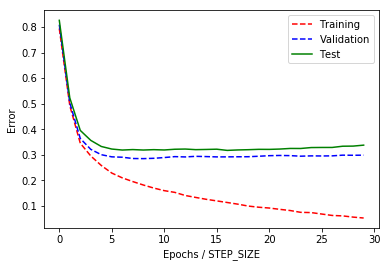

Accuracy with activation Sigmoid with opt: 'SGD' = 0.7080662386539655, es = 0.6826923064696484


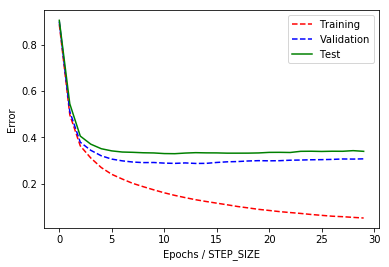

Accuracy with activation Sigmoid with opt: 'RMS' = 0.7121794887587556, es = 0.6704059837847693


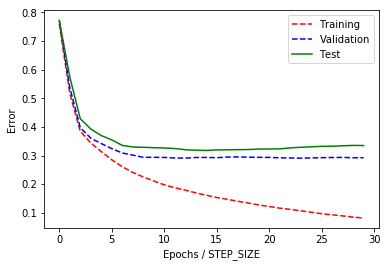

Accuracy with activation Sigmoid with opt: 'ADAM' = 0.7064102578366924, es = 0.6820512803064451


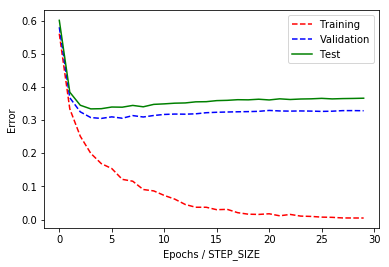

Accuracy with activation Tan_h with opt: 'SGD' = 0.6923611113021516, es = 0.6661858985566684


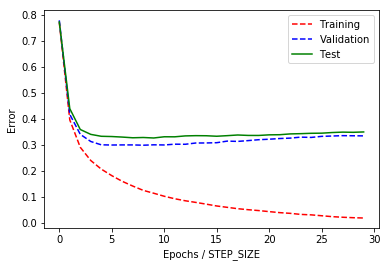

Accuracy with activation Tan_h with opt: 'RMS' = 0.6989850401368916, es = 0.6727029887274799


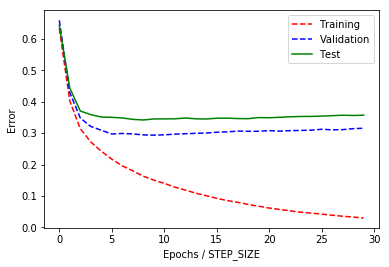

Accuracy with activation Tan_h with opt: 'ADAM' = 0.705715813443192, es = 0.6581730774325183
Initializing RELU-------------------------------


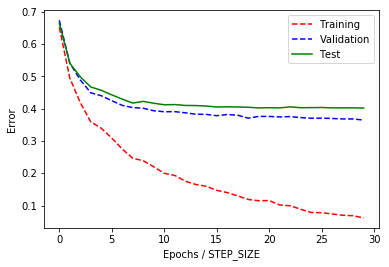

Accuracy with activation ReLU with opt: 'SGD' = 0.6354166666794027, es = 0.5981303407213627
Initializing RELU-------------------------------


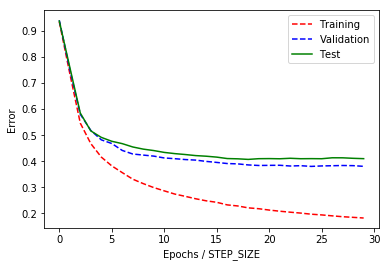

Accuracy with activation ReLU with opt: 'RMS' = 0.6136752147577766, es = 0.5924679485141722
Initializing RELU-------------------------------


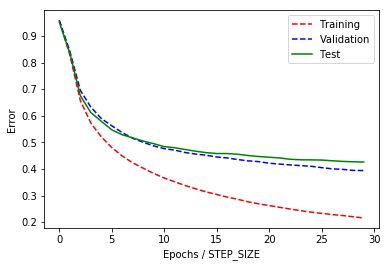

Accuracy with activation ReLU with opt: 'ADAM' = 0.606036325244822, es = 0.5740918763300293


In [79]:
EPOCHS = 300
BATCH_SIZE = 40
INDP_RUNS = 10
STEP_SIZE = 10

Algo = [tf.sigmoid, tf.tanh,tf.nn.relu]
names = ['Sigmoid', 'Tan_h', 'ReLU']
Opt = [tf.train.GradientDescentOptimizer,tf.train.RMSPropOptimizer, tf.train.AdamOptimizer]
#change here
rates = [0.1,0.0008, 0.0005]
Opt_name = ['SGD','RMS','ADAM']
for i in range(len(Algo)):
    #change here
    tf.reset_default_graph()
    x = tf.placeholder(tf.float32, (None, 300))
    y = tf.placeholder(tf.int32,(None))
    one_hot_y = tf.one_hot(y, 26)
    activation = Algo[i]
    for j in range(len(Opt)):
        with tf.Session() as sess:
            tr,va,es = try_comb(Train_Classifier(x,[20,26],activation) ,Opt[j], rates[j])
            plt.xlabel('Epochs / STEP_SIZE')
            plt.ylabel('Error')
            plt.plot(1 - np.array(tr),'r--',label = 'Training')
            plt.plot(1 - np.array(va),'b--', label = 'Validation')
            plt.plot(1 - np.array(es),'g', label = 'Test')
            plt.legend(loc='best')
            plt.show()
            print('Accuracy with activation {} with opt: \'{}\' = {}, es = {}'.format(names[i],Opt_name[j],va[np.argmax(es)],np.max(es)))

##  <font color='red'> Architectures Check </font>

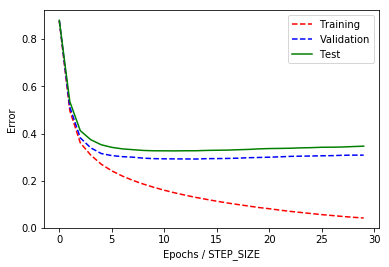

Accuracy with Architecture:[20] is = 0.7071474354644107, es = 0.6732905966221777


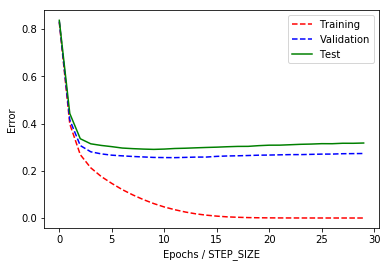

Accuracy with Architecture:[50] is = 0.7433653854152078, es = 0.7093162381598074


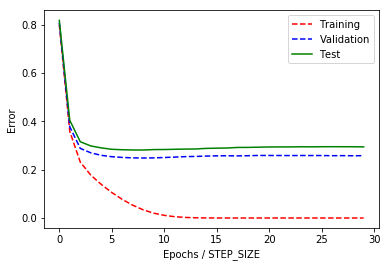

Accuracy with Architecture:[80] is = 0.7514850426127768, es = 0.7184081192582081


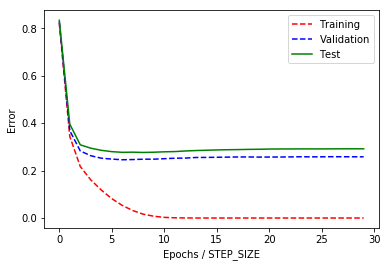

Accuracy with Architecture:[100] is = 0.7519551286483421, es = 0.72341880344937


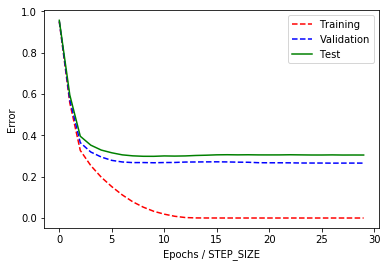

Accuracy with Architecture:[100, 50] is = 0.7324893167181912, es = 0.7013247861795955


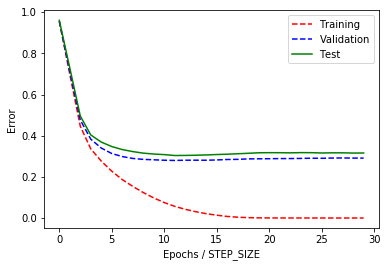

Accuracy with Architecture:[80, 20] is = 0.7202991454570722, es = 0.6962499993631983


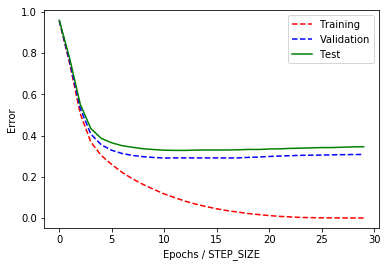

Accuracy with Architecture:[50, 20] is = 0.7078098288484108, es = 0.6715811966321408


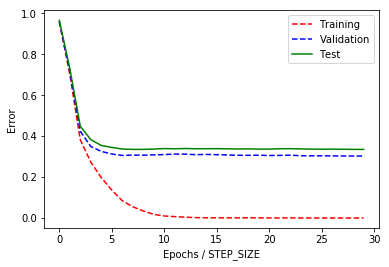

Accuracy with Architecture:[150, 100, 80] is = 0.6924572650744365, es = 0.6645085459081537


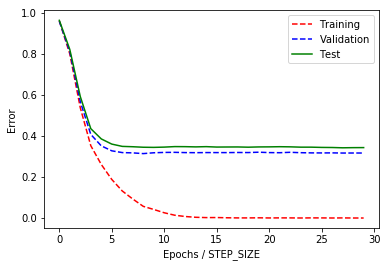

Accuracy with Architecture:[120, 80, 40] is = 0.6830876066949633, es = 0.6574786323461778


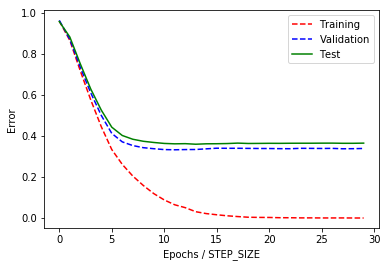

Accuracy with Architecture:[80, 40, 20] is = 0.6651068373546642, es = 0.6394017086935858


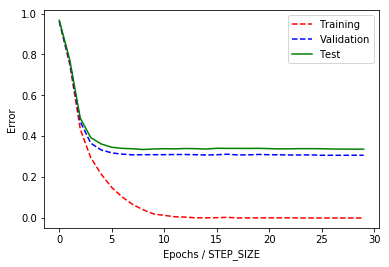

Accuracy with Architecture:[140, 90, 60] is = 0.6901923074605119, es = 0.6648931621460834


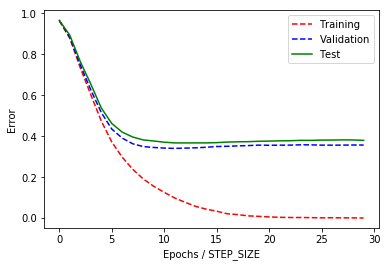

Accuracy with Architecture:[60, 30, 20] is = 0.6575320515418663, es = 0.6322970083967233


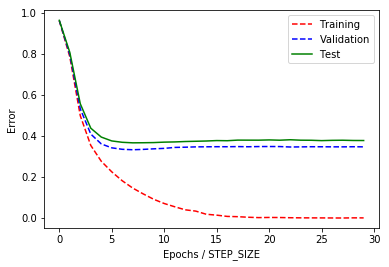

Accuracy with Architecture:[50, 100, 50] is = 0.6667841878355057, es = 0.6331089744939763


In [111]:
EPOCHS = 300
BATCH_SIZE = 40
INDP_RUNS = 10
STEP_SIZE = 10

chosen_opt = tf.train.RMSPropOptimizer
chosen_rate = 0.0008
chosen_activation = tf.sigmoid

neurons = {0:[20], 1:[50], 2:[80], 3:[100], 4:[100, 50], 5:[80, 20], 6:[50, 20], 7:[150,100,80], 8:[120, 80, 40],
           9:[80,40,20], 10:[140,90,60], 11:[60,30,20], 12:[50,100,50] }
for ii in range(len(neurons)):
    layers = neurons[ii]
    layers = np.append(layers,26)
    with tf.Session() as sess:
            tr,va,es = try_comb(Train_Classifier(x,layers,chosen_activation) ,chosen_opt,chosen_rate)
            plt.xlabel('Epochs / STEP_SIZE')
            plt.ylabel('Error')
            plt.plot(1 - np.array(tr),'r--',label = 'Training')
            plt.plot(1 - np.array(va),'b--', label = 'Validation')
            plt.plot(1 - np.array(es),'g', label = 'Test')
            plt.legend(loc='best')
            plt.show()
            print('Accuracy with Architecture:{} is = {}, es = {}'.format(neurons[ii],va[np.argmax(es)],np.max(es)))


Initializing RELU-------------------------------


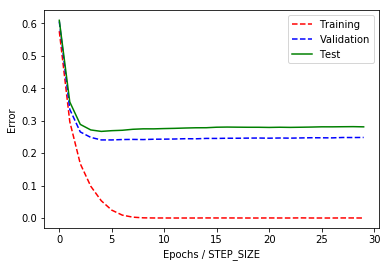

Accuracy with Architecture:[130] is = 0.7591452995681356, es = 0.7328739304267442
Initializing RELU-------------------------------


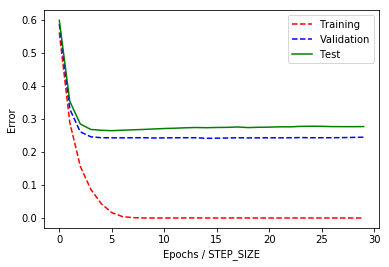

Accuracy with Architecture:[150] is = 0.7568482901245102, es = 0.7351602567515823


In [122]:
EPOCHS = 300
BATCH_SIZE = 40
INDP_RUNS = 10
STEP_SIZE = 10

chosen_opt = tf.train.GradientDescentOptimizer
chosen_rate = 0.1
chosen_activation = tf.sigmoid

#neurons = {0:[50], 1:[100], 2:[130], 3:[150], 4:[100, 50], 5:[80, 20], 6:[50, 20], 7:[150,100,80], 8:[120, 80, 40],
#           9:[80,40,20], 10:[140,90,60], 11:[60,30,20], 12:[50,100,50] }
#neurons = {0:[50], 1:[100], 2:[130], 3:[150] }
neurons = {0:[130], 1:[150] }
for ii in range(len(neurons)):
    layers = neurons[ii]
    layers = np.append(layers,26)
    with tf.Session() as sess:
            tr,va,es = try_comb(Train_Classifier(x,layers,chosen_activation) ,chosen_opt,chosen_rate)
            plt.xlabel('Epochs / STEP_SIZE')
            plt.ylabel('Error')
            plt.plot(1 - np.array(tr),'r--',label = 'Training')
            plt.plot(1 - np.array(va),'b--', label = 'Validation')
            plt.plot(1 - np.array(es),'g', label = 'Test')
            plt.legend(loc='best')
            plt.show()
            print('Accuracy with Architecture:{} is = {}, es = {}'.format(neurons[ii],va[np.argmax(es)],np.max(es)))


In [ ]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train,y_train)

from sklearn.model_selection import train_test_split
# First split in 70% -- 30%
X_train2, X_temp, y_train2, y_temp  = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

#Split the 30% into half to get 15% -- 15% (from X_train)for validation and early stop
X_validation, X_stop, y_validation, y_stop = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

n_input = len(X_train2)

In [123]:
X_train2 = np.concatenate((X_train2, X_validation),axis = 0)
y_train2 = np.concatenate((y_train2, y_validation),axis = 0)
X_validation = X_stop
y_validation = y_stop

X_stop = X_test
y_stop = y_test

In [124]:
print(X_train2.shape)
print(y_train2.shape)
print(X_validation.shape)
print(y_validation.shape)
print(X_stop.shape)
print(y_stop.shape)

(5302, 300)
(5302,)
(936, 300)
(936,)
(1559, 300)
(1559,)


In [127]:
def try_on_test(classifier,optimizer, rate):
    err = 0
    for i in range(INDP_RUNS):
        tr,te,es= train(classifier,optimizer,rate,stop_on_convergence=True,ret ='plots')
        plt.xlabel('Epochs')
        plt.ylabel('Error')
        plt.plot(1 - np.array(tr),'r--',label = 'Training')
        plt.plot(1 - np.array(te),'b--', label = 'Validation')
        plt.plot(1 - np.array(es),'g', label = 'Test')
        plt.legend(loc='best')
        plt.show()
        err += np.max(es)
    return err / INDP_RUNS

Initializing RELU-------------------------------
#############STOP################


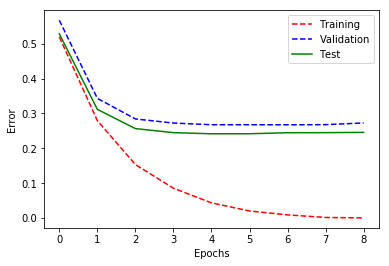

#############STOP################


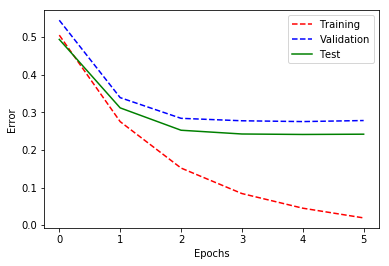

#############STOP################


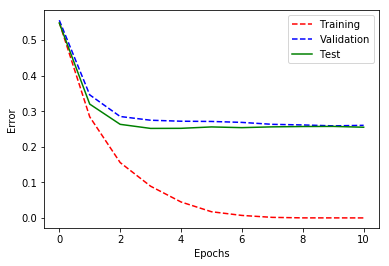

#############STOP################


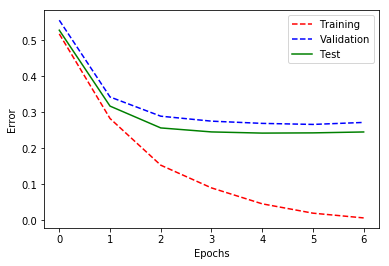

#############STOP################


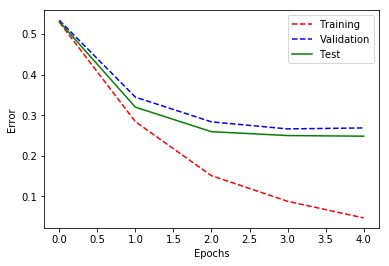

#############STOP################


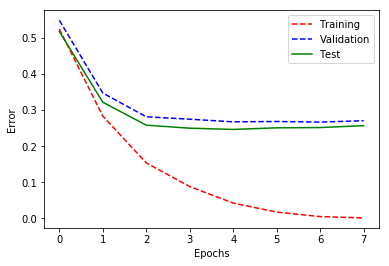

#############STOP################


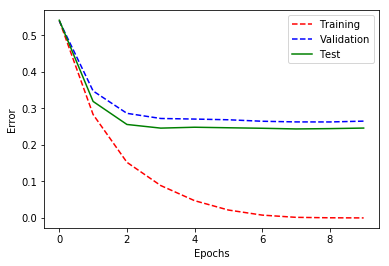

#############STOP################


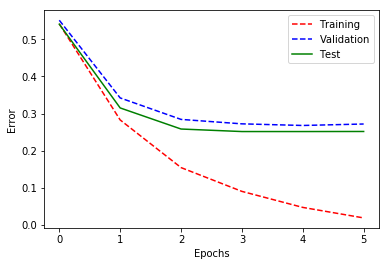

#############STOP################


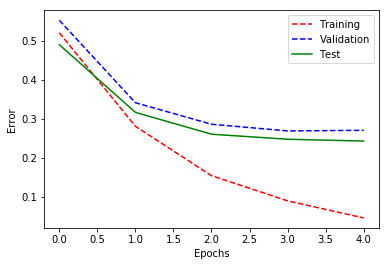

#############STOP################


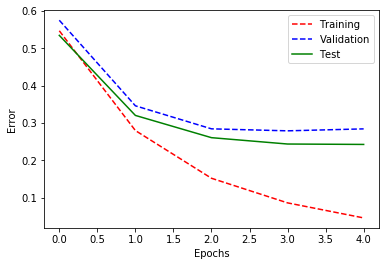

0.754753046501


In [128]:
chosen_opt = tf.train.AdamOptimizer
chosen_rate = 0.0005
chosen_activation = tf.nn.relu

layers = [130]
layers = np.append(layers,26)
with tf.Session() as sess:
    print(try_on_test(Train_Classifier(x,layers,chosen_activation) ,chosen_opt,chosen_rate))